In [19]:
# import YOLOP dependencies
# import sys
# sys.path.append('/s/dat/UserFolders/xzhan258/private_dev/DatasetEquity/YOLOP')
# from lib.utils.utils import select_device
# from lib.config import cfg
# from lib.models import get_net
# from pathlib import Path

# import clustering method
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn import metrics
from tqdm.notebook import tqdm
from PIL import Image

# import torch, cv2 and other dependencies
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet101

import os
import cv2
import pickle
import logging
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import math

In [20]:
# set random seed
import random
random.seed(33)
np.random.seed(33)

# Create BDD100k dataset loader

In [21]:
class BDD100kDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        dataroot,
        image_set="train",
        transform=transforms.Compose([transforms.Resize((384, 384)), 
                                      transforms.ToTensor(),
                                      transforms.Normalize(0.5, 0.5),
                                      ]),
        is_test=False,
        keep_difficult=False,
        label_file=None,
        version='100k',
        split='train'
    ):
        """Dataset for BDD100k data.
        Args:
            dataroot: the root of the BDD100k dataset, 
        """
        self.dataroot = dataroot
        self.transform = transform
        self.version = version
        self.split = split
        self.filenames, self.tokens = [], []
        
        if self.version in ['10k', '100k']: 
            self.dataroot = os.path.join(self.dataroot, self.version, self.split)
        else:
            assert self.version in ['10k','100k']
            print('Please use either 10k samples version or 100k full dataset')
        
        #pbar = tqdm(enumerate(os.listdir(self.dataroot)))
        #for filename in os.listdir(self.data_dir):
        img_list = os.listdir(self.dataroot)
        for idx, filename in enumerate(tqdm(img_list)):
            img_path = os.path.join(self.dataroot, filename)
            self.filenames.append(img_path)
            self.tokens.append(idx)
            
        print('Number of data samples in the set: {}'.format(len(self.filenames)))

    # method to get length of data
    def __len__(self):
        return len(self.filenames)

    # method to get a sample
    def __getitem__(self, idx):
        # get image
        image_filename = self.filenames[idx]
        image = Image.open(image_filename).convert('RGB')
        # transform image
        image = self.transform(image)
        # get token
        token = self.tokens[idx]
        # return image
        return {'image': image, 'token': token}


In [22]:
dataset = BDD100kDataset(dataroot='/s/dat/UserFolders/xzhan258/LaneDetection/BDD100K/bdd100k_images/bdd100k/images', 
                         version='100k', 
                         split='train')

  0%|          | 0/48156 [00:00<?, ?it/s]

Number of data samples in the set: 48156


# Define paths and dataset

In [3]:
DEV_ROOT = '/s/dat/UserFolders/xzhan258/private_dev/DatasetEquity/data_analysis/bdd100k'
dataset_str='bdd100k'
train_features_fname = os.path.join(DEV_ROOT, f'{dataset_str}_training_features.pkl')
train_cluster_info_fname = os.path.join(DEV_ROOT, f'{dataset_str}_training_cluster_info.pkl')

In [4]:
print(train_features_fname)

/s/dat/UserFolders/xzhan258/private_dev/DatasetEquity/data_analysis/bdd100k/bdd100k_training_features.pkl


# Compute features from raw dataset

## option #1 load torch pretrained models

In [ ]:
if not os.path.exists(train_features_fname):
    # use a pre-trained model to get the feature vectors for all the images
    # in the dataset
    model = resnet101(pretrained=True, progress=True)
    # remove the last layer keeping the weights
    model = torch.nn.Sequential(*list(model.children())[:-1])

    model.eval()
    model.cuda()
    train_tokens, train_features = [], []
    with torch.no_grad():
        for i in tqdm(range(len(dataset))):
            img = dataset[i]['image'].unsqueeze(0).cuda()
            # inference
            feature = model(img).flatten().cpu().numpy()
            train_features.append(feature)
            train_tokens.append(dataset[i]['token'])
    train_features = np.array(train_features)
    # save the features to disk as a pickle file
    with open(train_features_fname, 'wb') as f:
        pickle.dump({'tokens': train_tokens, 'features': train_features}, f)

  0%|          | 0/48156 [00:00<?, ?it/s]

## option #2 load other models

In [23]:
def yolop(pretrained=True, device="cpu"):
    """Creates YOLOP model
    Arguments:
        pretrained (bool): load pretrained weights into the model
        wieghts (int): the url of pretrained weights
        device (str): cuda device i.e. 0 or 0,1,2,3 or cpu
    Returns:
        YOLOP pytorch model
    """
    device = select_device(device = device)
    model = get_net(cfg)
    if pretrained:
        path = '/s/dat/UserFolders/xzhan258/private_dev/DatasetEquity/YOLOP/weights/End-to-end.pth'
        checkpoint = torch.load(path, map_location= device)
        model.load_state_dict(checkpoint['state_dict'])
    model = model.to(device)
    return model

#could also load other pretrained model
# model = yolop(pretrained=True, device="cuda")
# model.gr = 1.0
# model.nc = 1
# model.eval()
# model.cuda()

# Compute clusters in a lower-dimensional space for training dataset

Projecting training dataset features to 2D...
[t-SNE] Computing 658 nearest neighbors...
[t-SNE] Indexed 48156 samples in 0.043s...
[t-SNE] Computed neighbors for 48156 samples in 19.553s...
[t-SNE] Computed conditional probabilities for sample 1000 / 48156
[t-SNE] Computed conditional probabilities for sample 2000 / 48156
[t-SNE] Computed conditional probabilities for sample 3000 / 48156
[t-SNE] Computed conditional probabilities for sample 4000 / 48156
[t-SNE] Computed conditional probabilities for sample 5000 / 48156
[t-SNE] Computed conditional probabilities for sample 6000 / 48156
[t-SNE] Computed conditional probabilities for sample 7000 / 48156
[t-SNE] Computed conditional probabilities for sample 8000 / 48156
[t-SNE] Computed conditional probabilities for sample 9000 / 48156
[t-SNE] Computed conditional probabilities for sample 10000 / 48156
[t-SNE] Computed conditional probabilities for sample 11000 / 48156
[t-SNE] Computed conditional probabilities for sample 12000 / 48156
[t

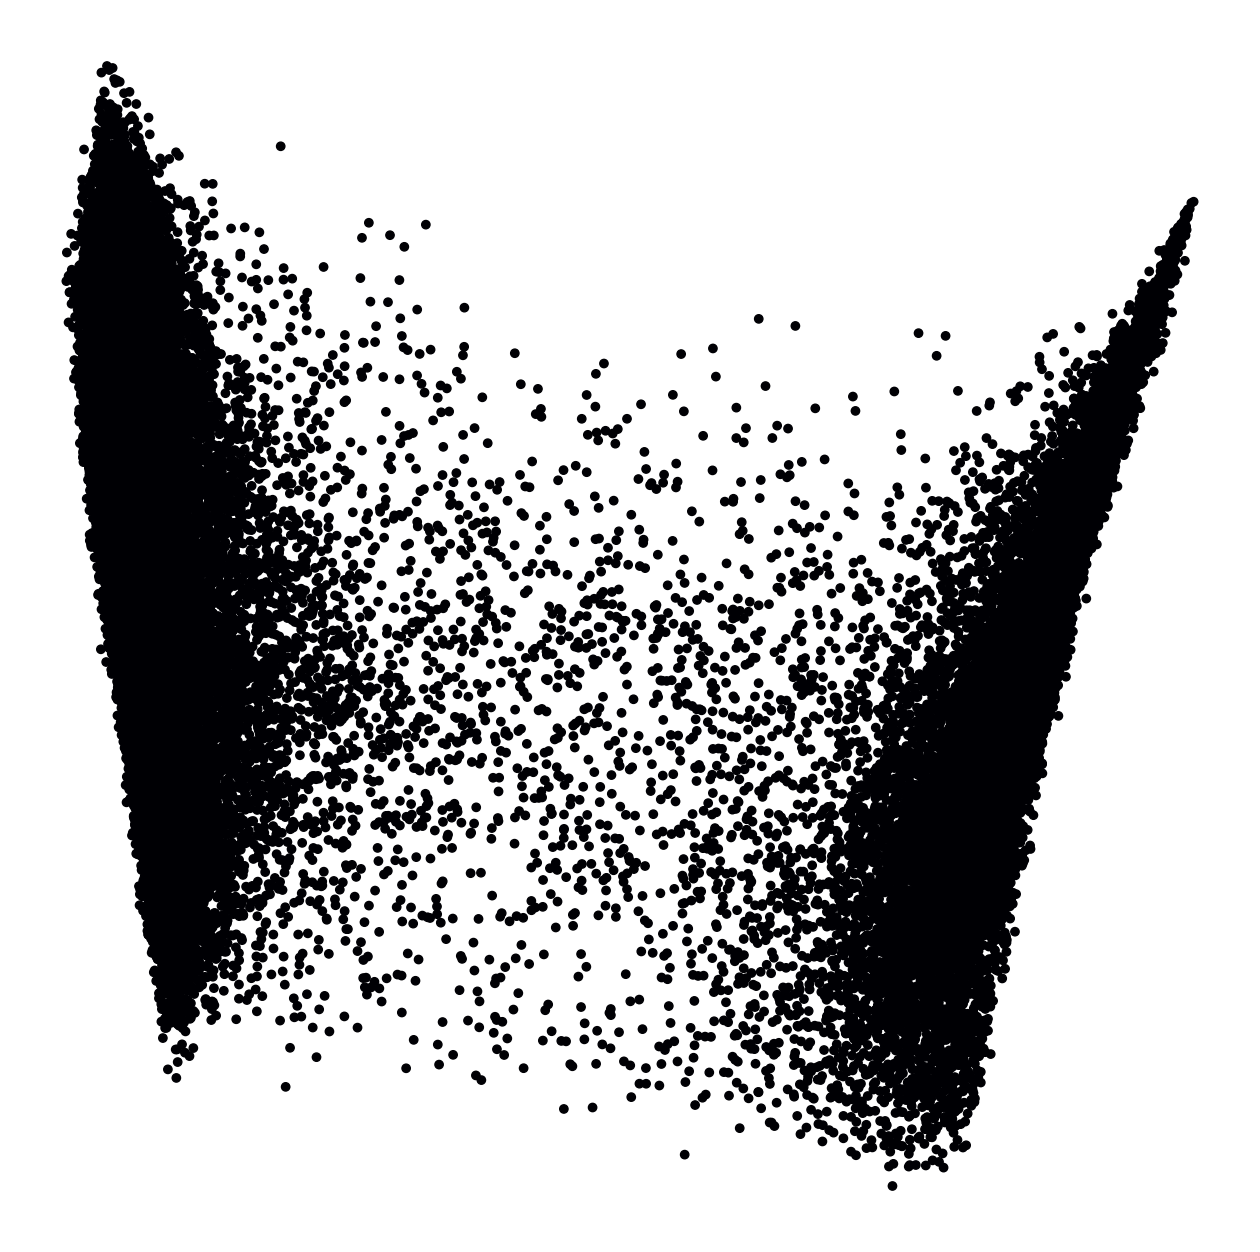

In [24]:
# load the training features from disk
data = pickle.load(open(train_features_fname, 'rb'))
train_tokens, train_features = \
    data['tokens'], data['features']

# project the features onto a 2D t-SNE plot
print('Projecting training dataset features to 2D...')

num_dimensions = 2
learning_rate= 1
num_images = 48156
verbose = 2
n_iteraions = 500
random_num = int(random.random())        

tsne = TSNE(n_components=num_dimensions, 
            learning_rate = learning_rate,
            perplexity=round(math.sqrt(num_images)),
            random_state = random_num,
            verbose=verbose, 
            n_iter=n_iteraions)
tsne_results = tsne.fit_transform(train_features)
# find clusters using DBSCAN

db = DBSCAN(eps=0.5 , min_samples=5).fit(tsne_results)
print('Number of clusters: {}'.format(len(np.unique(db.labels_))))
labels = db.labels_

# visualize the clusters
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], c=labels, cmap='inferno')
ax.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap='inferno')
plt.axis('off')

plt.savefig(os.path.join(DEV_ROOT, f'{dataset_str}_training_clusters_50k.png'), bbox_inches='tight', pad_inches=0)
plt.show()

In [25]:
# sort clusters in the order of most common to rare
unique_cluster_ids = np.unique(labels)
cluster_sizes = {cl_id: np.sum(labels == cl_id) for cl_id in unique_cluster_ids}
unique_cluster_ids = sorted(unique_cluster_ids, key=lambda i: cluster_sizes[i])
largest_cluster_size = cluster_sizes[unique_cluster_ids[-1]]

In [26]:
# get the cluster id and cluster size for each image
train_dataset_cluster_info = {}
for i in range(len(train_tokens)):
    cluster_info = {'cluster_id': labels[i], 
                    'cluster_size': np.sum(labels == labels[i]), 
                    'largest_cluster_size': largest_cluster_size}
    train_dataset_cluster_info[train_tokens[i]] = cluster_info
# save the cluster info to disk
with open(train_cluster_info_fname, 'wb') as f:
    pickle.dump(train_dataset_cluster_info, f)
    print('Saved training cluster info to {}'.format(train_cluster_info_fname))

Saved training cluster info to /s/dat/UserFolders/xzhan258/private_dev/DatasetEquity/data_analysis/bdd100k/bdd100k_training_cluster_info.pkl


In [27]:
# load cluster info from disk
train_dataset_cluster_info = pickle.load(open(train_cluster_info_fname, 'rb'))

# Show stats about clusters

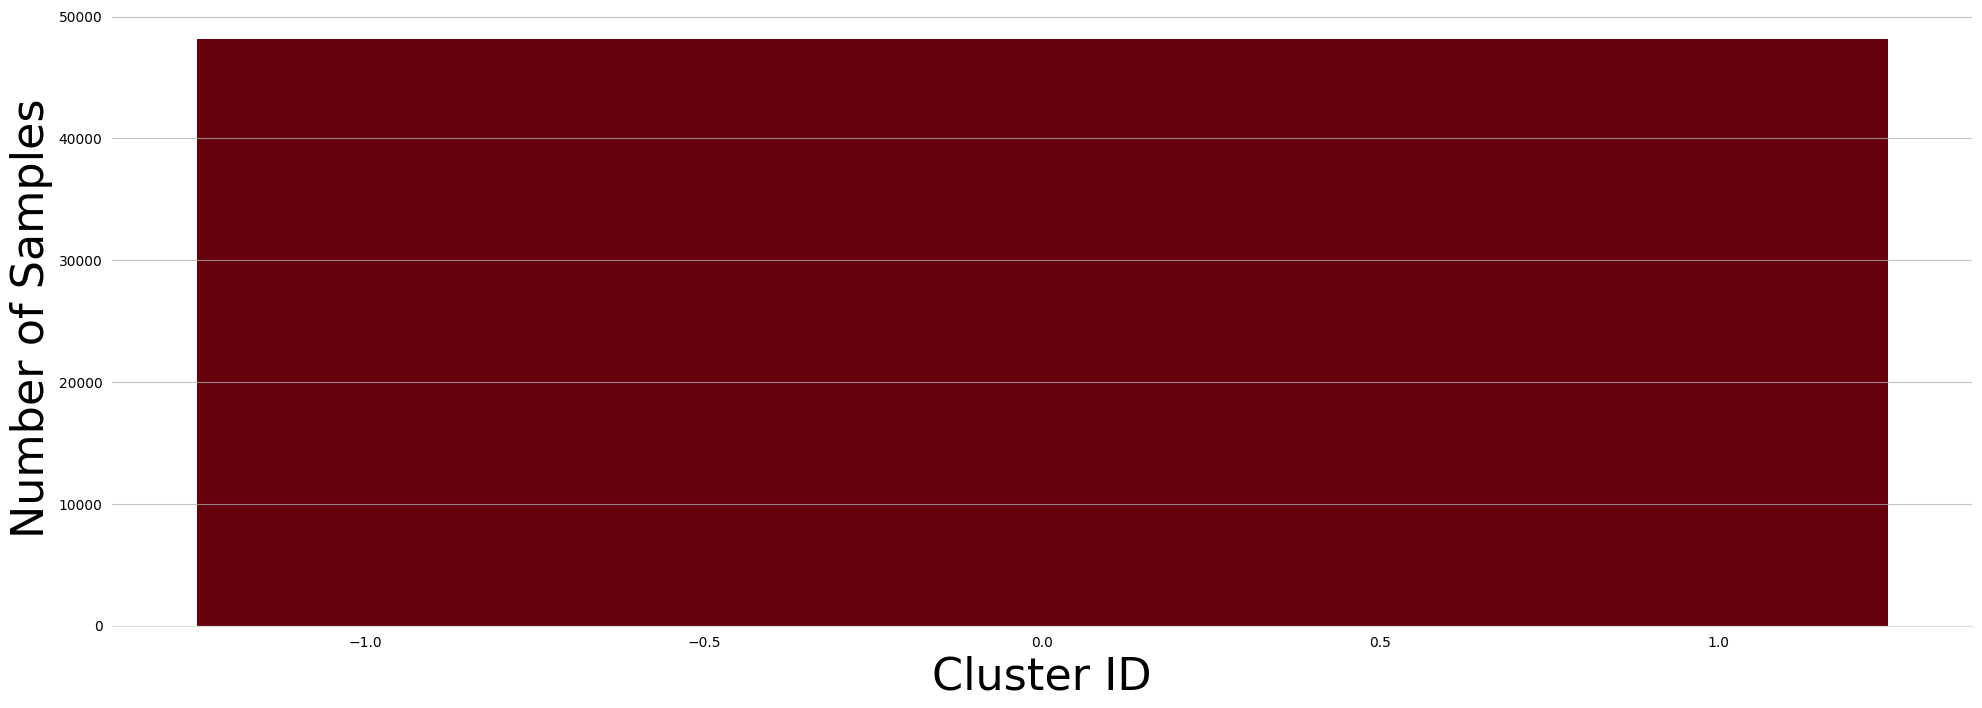

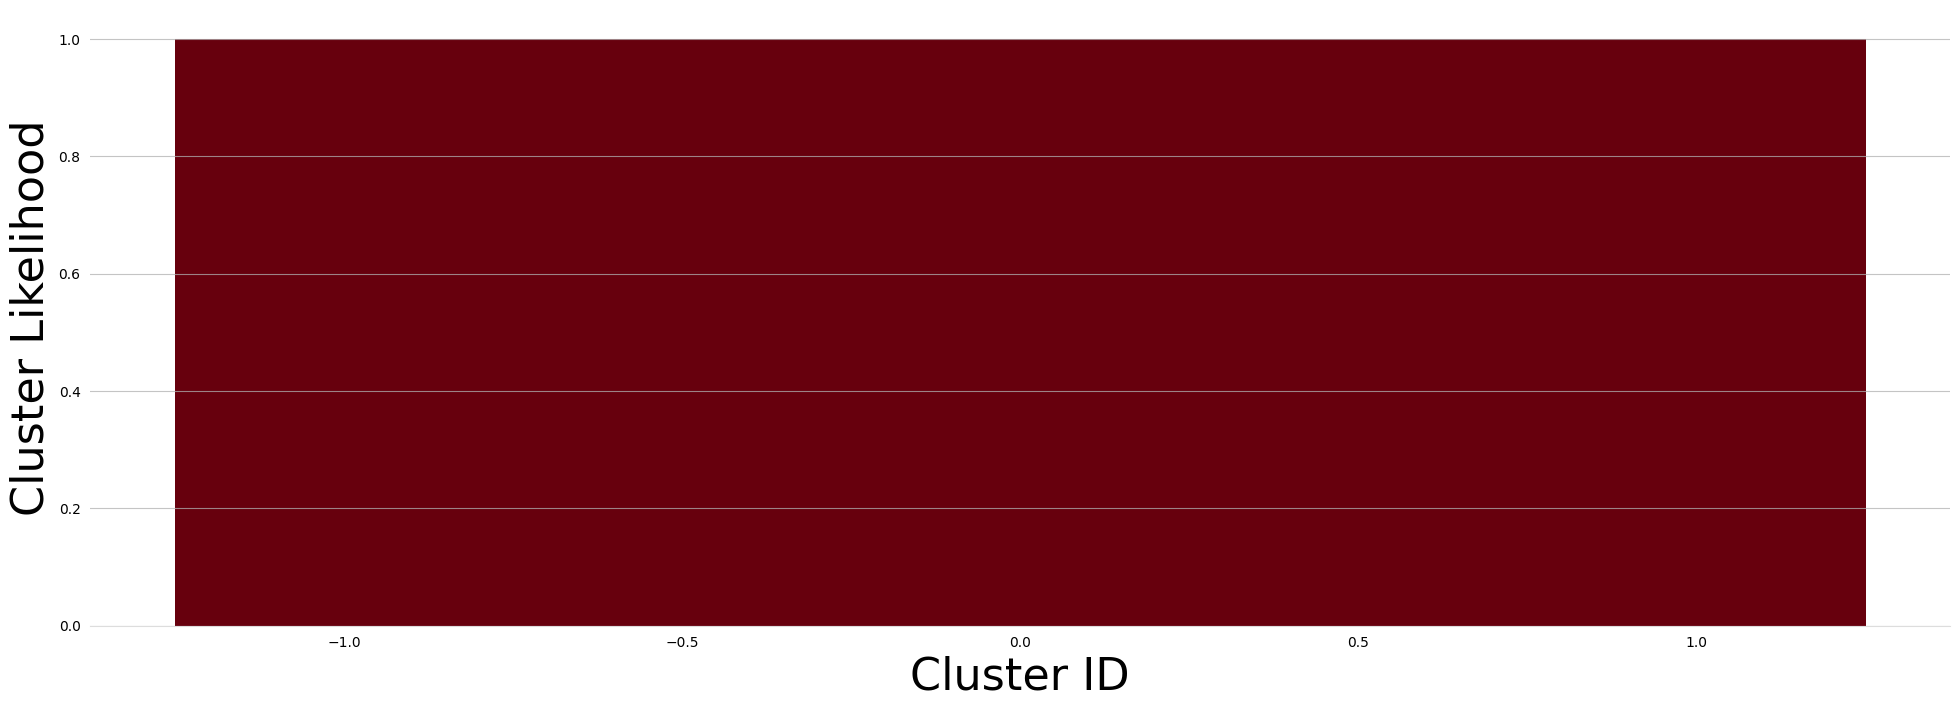

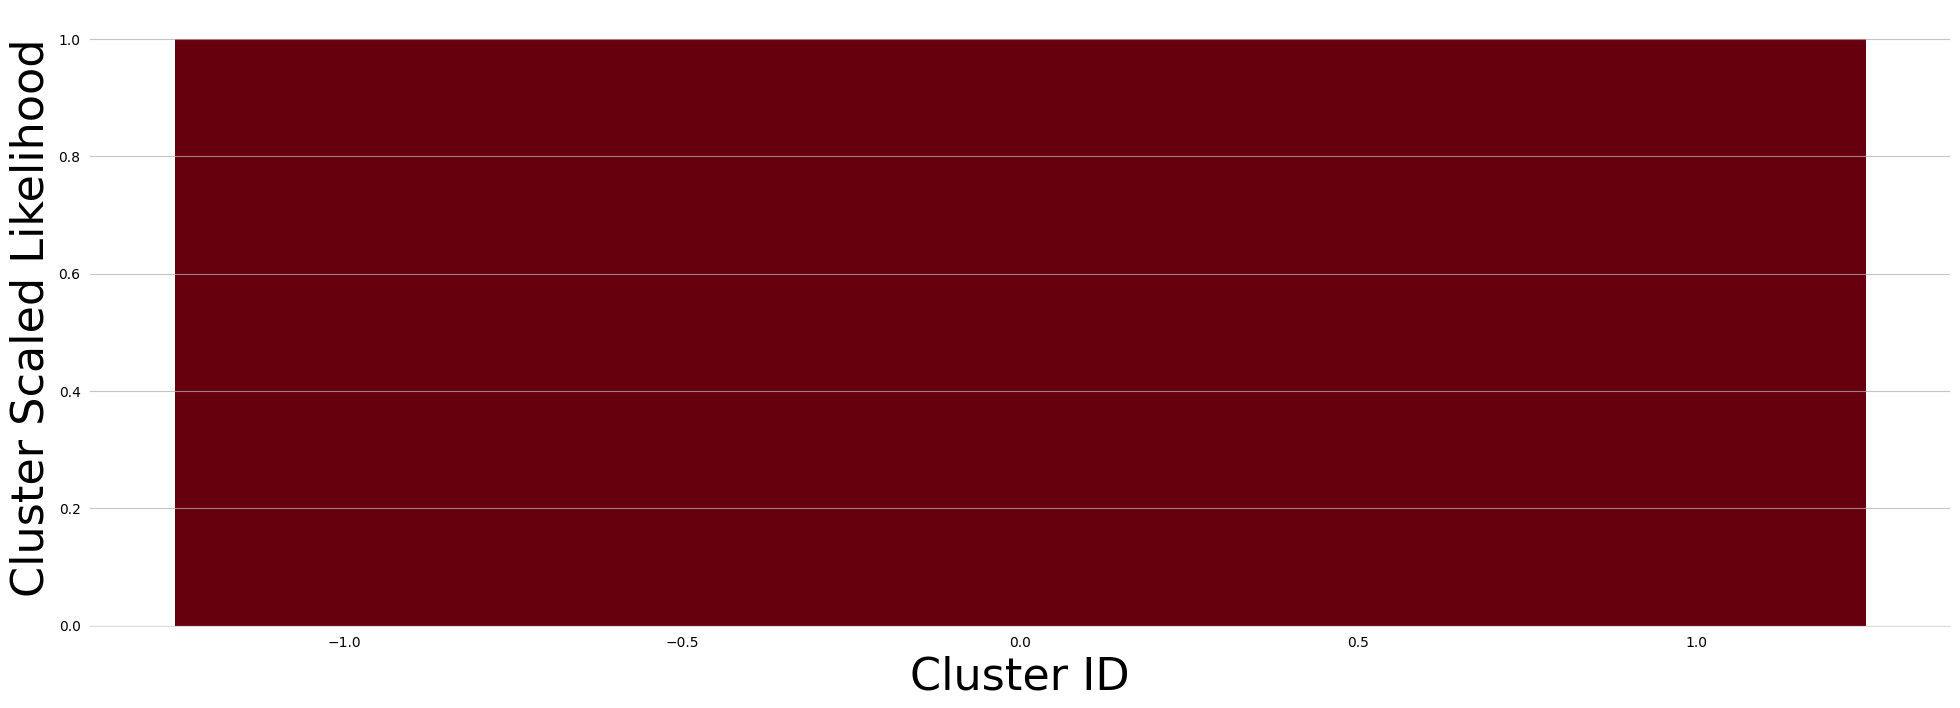

In [28]:
id_list, n_samples, sample_likelihood, sample_scaled_likelihood = \
    [], [], [], []
for i in range(len(np.unique(labels))):
    cluster_ids = np.array(train_tokens)[labels == i]
    id_list.append(i)
    n_samples.append(len(cluster_ids))
    sample_likelihood.append(len(cluster_ids) / len(dataset))
    sample_scaled_likelihood.append(len(cluster_ids) / largest_cluster_size)


# plot histogram
fig, ax = plt.subplots(figsize=(24, 8))
# color each bar based on its height and color as hue of red
colors = plt.cm.Reds(0.5 + np.array(n_samples) / (2 * np.max(n_samples)))
ax.bar(id_list, n_samples, width = 2.5, color=colors)
ax.grid(axis='y', alpha=0.75)

ax.set_xlabel('Cluster ID', fontsize=32)
ax.set_ylabel('Number of Samples', fontsize=32)

# let's remove the top, right and left spines (figure borders)
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# remove the ticks as well.
ax.tick_params(bottom=False, left=False)
plt.show()

# plot cluster sample likelihood
fig, ax = plt.subplots(figsize=(24, 8))
# color each bar based on its height and color as hue of red
colors = plt.cm.Reds(0.5 + np.array(sample_likelihood) / (2 * np.max(sample_likelihood)))
ax.bar(id_list, sample_likelihood, width = 2.5, color=colors)
ax.grid(axis='y', alpha=0.75)

ax.set_xlabel('Cluster ID', fontsize=32)
ax.set_ylabel('Cluster Likelihood', fontsize=32)

# let's remove the top, right and left spines (figure borders)
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# remove the ticks as well.
ax.tick_params(bottom=False, left=False)
plt.show()

# plot cluster sample likelihood
fig, ax = plt.subplots(figsize=(24, 8))
# color each bar based on its height and color as hue of red
colors = plt.cm.Reds(0.5 + np.array(sample_scaled_likelihood) / (2 * np.max(sample_scaled_likelihood)))
ax.bar(id_list, sample_scaled_likelihood, width = 2.5, color=colors)
ax.grid(axis='y', alpha=0.75)

ax.set_xlabel('Cluster ID', fontsize=32)
ax.set_ylabel('Cluster Scaled Likelihood', fontsize=32)

# let's remove the top, right and left spines (figure borders)
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# remove the ticks as well.
ax.tick_params(bottom=False, left=False)
# plt.tight_layout()
plt.savefig(f'plots/{dataset_str}_dataset_likelihood.png')
plt.show()